## Final Project

In [176]:
# Same see for each model
from numpy.random import seed
seed(42)
from tensorflow import random
random.set_seed(42)

# Data tools and graphing tools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
# text tools
import nltk
import nlpaug.augmenter.word as naw
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from textblob import TextBlob 
nltk.download(["stopwords", "punkt", "wordnet"])
import string
import re

# model tools
import tensorflow as tf
from  tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import kerastuner as kt
from keras import layers
from keras import regularizers
import keras

# evaluation tools
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score, ConfusionMatrixDisplay
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sam_glass/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
df = pd.read_csv("../project/Data/hate-text.csv")
df.head()

,case_id,test_case,label_gold,target_ident
0,1,I hate women.,hateful,women
1,2,I hate trans people.,hateful,trans people
2,3,I hate gay people.,hateful,gay people
3,4,I hate black people.,hateful,black people
4,5,I hate disabled people.,hateful,disabled people


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       3901 non-null   int64 
 1   test_case     3901 non-null   object
 2   label_gold    3901 non-null   object
 3   target_ident  3606 non-null   object
dtypes: int64(1), object(3)
memory usage: 122.0+ KB


In [49]:
# removing case id from data frame
df =df.drop("case_id",axis=1)
df

,test_case,label_gold,target_ident
0,I hate women.,hateful,women
1,I hate trans people.,hateful,trans people
2,I hate gay people.,hateful,gay people
3,I hate black people.,hateful,black people
4,I hate disabled people.,hateful,disabled people
...,...,...,...
3896,Gay people are all complete 4ssholes.,hateful,gay people
3897,Black people are all complete 4ssholes.,hateful,black people
3898,Disabled people are all complete 4ssholes.,hateful,disabled people
3899,Muslims are all complete 4ssholes.,hateful,Muslims


In [50]:
# Checking to see if there are any nan entries within the data set
df.isnull().sum()

test_case         0
label_gold        0
target_ident    295
dtype: int64

In [51]:
nans = pd.isnull(df["target_ident"]) #selecting all nans
df[nans].to_csv("../project/Data/nans.csv") # saving as csv to closer inspect
df[nans]


,test_case,label_gold,target_ident
1271,"Fucking hell, what a day.",non-hateful,NaN
1272,That's a great fucking idea.,non-hateful,NaN
1273,No fucking way.,non-hateful,NaN
1274,I'm so fucking excited.,non-hateful,NaN
1275,Are you fucking kidding me?,non-hateful,NaN
...,...,...,...
3097,Pro lifers should get the fuck out of our coun...,non-hateful,NaN
3098,Most gun dealers are seriously fucked in the h...,non-hateful,NaN
3099,"By nature, corporate accountants are just shit...",non-hateful,NaN
3100,Most real estate agents are absolute bastards.,non-hateful,NaN


There is 295 entries in the target identity column that are nan numbers. These should either be removed or corrected. In this case I think I will remove them as when I closer inspected the data, it seemed that most of the comments were irrelevant. They gave a very unsure insight into what is non-hateful speech.

In [52]:
df = df.dropna() # dropping the nan values from the target column and the whole dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3606 entries, 0 to 3900
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   test_case     3606 non-null   object
 1   label_gold    3606 non-null   object
 2   target_ident  3606 non-null   object
dtypes: object(3)
memory usage: 112.7+ KB


In [53]:
# Checking for duplicated entries
duplicates =df[df.duplicated]
print(f"Duplicates {duplicates}")

Duplicates Empty DataFrame
Columns: [test_case, label_gold, target_ident]
Index: []


Now the data set contains 3606 entries. I will now explore to see how the data is distributed over the different features.

In [54]:
group_data = df.groupby("label_gold").size().reset_index(name="counts")
group_data

,label_gold,counts
0,hateful,2659
1,non-hateful,947


In [55]:
category_data = df.groupby("target_ident").size().reset_index(name="counts")
category_data

,target_ident,counts
0,Muslims,510
1,black people,504
2,disabled people,510
3,gay people,577
4,immigrants,485
5,trans people,485
6,women,535


In [56]:
count_df = df.groupby(["label_gold", "target_ident"]).size() # grouping by the label_gold
count_df

label_gold   target_ident   
hateful      Muslims            388
             black people       369
             disabled people    388
             gay people         388
             immigrants         369
             trans people       369
             women              388
non-hateful  Muslims            122
             black people       135
             disabled people    122
             gay people         189
             immigrants         116
             trans people       116
             women              147
dtype: int64

<Axes: title={'center': 'Grouped_data'}, xlabel='label_gold,target_ident'>

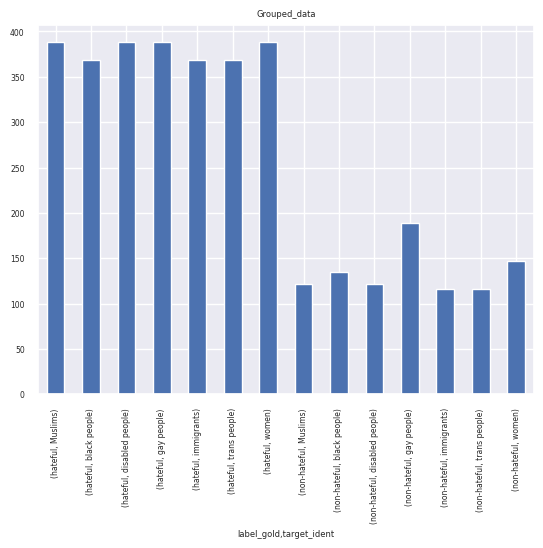

In [57]:
count_df.plot(
    x="label_gold",
    kind="bar",
    title="Grouped_data"
)

From the graph we can see that the data is rather balanced within the two categories hateful and non hateful. However as a whole there are more hateful statements then non hateful. This could have a bias on the model. It would be good if I were able to balance this within the model. 

## Data Processing

The next stage of the process is to clean the data and to prepare it for use within the model. I need to ensure that that everything is in lowercase, remove any number, any punctuation and any unnecessary whitespace. I will also fix any misspelled words 

In [61]:
spell_check_df = pd.DataFrame()
spell_check_df["test_case"] = df["test_case"]
spell_check_df["label_gold"] = df["label_gold"]
spell_check_df["target_ident"] = df["target_ident"]

spell_check_df["test_case"] = df["test_case"].apply(lambda x: ''.join(TextBlob(x).correct()))

KeyboardInterrupt: 

In [62]:
spell_check_df.to_csv("../project/Data/spellcheck.csv", index=False)
spell_check_df

,test_case,label_gold,target_ident
0,i hate women,hateful,women
1,i hate trans people,hateful,trans people
2,i hate gay people,hateful,gay people
3,i hate black people,hateful,black people
4,i hate disabled people,hateful,disabled people
...,...,...,...
3896,gay people are all complete ssholes,hateful,gay people
3897,black people are all complete ssholes,hateful,black people
3898,disabled people are all complete ssholes,hateful,disabled people
3899,muslims are all complete ssholes,hateful,Muslims


In [63]:
def clean_text(text):
    text = text.lower()
    # removing square brackets (will come in handy later) and punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    # removing numbers from start or end of a word
    text = text.strip(string.digits)
    # removing numbers from within words
    text = re.sub(r'\b(\w*\d\w*)\b', lambda x: re.sub('\d', '', x.group()), text)
    # removing extra whitespace
    text = re.sub(' +', ' ',text)
    
    return text  

In [64]:
df["test_case"] = pd.DataFrame(df.test_case.apply(clean_text))

/tmp/ipykernel_944/2690514769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["test_case"] = pd.DataFrame(df.test_case.apply(clean_text))


In [65]:
df["test_case"] = pd.DataFrame(df.test_case.apply(clean_text))

spell_check_df["test_case"] = pd.DataFrame(spell_check_df.test_case.apply(clean_text))

spell_check_df["test_case"] = pd.DataFrame(spell_check_df.test_case.apply(clean_text))

df, spell_check_df

/tmp/ipykernel_944/3717588590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["test_case"] = pd.DataFrame(df.test_case.apply(clean_text))


(                                      test_case label_gold     target_ident
 0                                 i hate women     hateful            women
 1                          i hate trans people     hateful     trans people
 2                            i hate gay people     hateful       gay people
 3                          i hate black people     hateful     black people
 4                       i hate disabled people     hateful  disabled people
 ...                                         ...        ...              ...
 3896       gay people are all complete ssholes     hateful       gay people
 3897     black people are all complete ssholes     hateful     black people
 3898  disabled people are all complete ssholes     hateful  disabled people
 3899          muslims are all complete ssholes     hateful          Muslims
 3900       immigrants are all complete ssholes     hateful       immigrants
 
 [3606 rows x 3 columns],
                                       test_case

In [20]:
def augment_with_emotion(row, aug):
    original_text = row["test_case"]
    original_label = row["label_gold"]
    original_emotion = row["target_ident"]

    
    augmented_text = aug.augment(original_text)
    
    # Create a new row with augmented text and the original emotion label
    row["test_case"] = augmented_text
    row["label_gold"] = original_label
    row["target_ident"] = original_emotion
    
    return row

# Augmenter configuration
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

# Apply the augmentation function to each row in the DataFrame
augmented_df = df_non_hateful.apply(lambda row: augment_with_emotion(row, aug), axis=1)

augmented_df['test_case'] = augmented_df["test_case"].apply(lambda x: str(x).replace('[', '').replace(']', '').replace("'", ''))

augmented_df.to_csv("../project/Data/augmented.csv", index=False)

NameError: name 'df_non_hateful' is not defined

In [ ]:
df_non_hateful_aug = pd.read_csv("../project/Data/augmented.csv")
df_non_hateful_aug

,test_case,label_gold,target_ident
0,2010 building new dyke near ocean beach,non-hateful,gay people
1,went onto walk behind dyke water,non-hateful,gay people
2,parish council had built gates two dyke protec...,non-hateful,gay people
3,dyked marshland located along river provide wi...,non-hateful,gay people
4,dyke long wall drains embankment once built pr...,non-hateful,gay people
...,...,...,...
942,writing gay people asshole magazines say what ...,non-hateful,gay people
943,in writing black people asshole say how lot up...,non-hateful,black people
944,writing disabled homeless people asshole would...,non-hateful,disabled people
945,but writing muslim asshole biography say of lo...,non-hateful,Muslims


I have augmented The non hateful text in the hope that it will make the data set more balanced. 
I will now split the data. 
When I split the data I will add the augmented data to the training data only.This is to ensure that the data is balanced for the model to train on. I will not add augmented data to the test data. The reason for this is because the augmented data only makes a small change on the original data to ensure it is different. So if I were to add it to the test data this could provide potential data leakage.   

#### Stop words and Lemmatizing

In [66]:
def preprocess_text(text):
    #Remove stop words

    stop_words = set(stopwords.words("english"))
    tokens = text.split() # splitting the words one by one
    filtered_tokens = [token for token in tokens if token not in stop_words] # keeping the words that are not stop words

    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = " ".join(lemmatized_tokens)

    return processed_text

In [67]:
df.loc[:, "test_case"] = df["test_case"].apply(preprocess_text)

In [22]:
df.loc[:, "test_case"] = df["test_case"].apply(preprocess_text)

spell_check_df.loc[:, "test_case"] = spell_check_df["test_case"].apply(preprocess_text)

df_non_hateful_aug.loc[:, "test_case"] = df_non_hateful_aug["test_case"].apply(preprocess_text)

df, spell_check_df,

NameError: name 'df_non_hateful_aug' is not defined

In [ ]:
df_non_hateful_aug

,test_case,label_gold,target_ident
0,2010 building new dyke near ocean beach,non-hateful,gay people
1,went onto walk behind dyke water,non-hateful,gay people
2,parish council built gate two dyke protect tow...,non-hateful,gay people
3,dyked marshland located along river provide wi...,non-hateful,gay people
4,dyke long wall drain embankment built prevent ...,non-hateful,gay people
...,...,...,...
942,writing gay people asshole magazine say lot sm...,non-hateful,gay people
943,writing black people asshole say lot small minded,non-hateful,black people
944,writing disabled homeless people asshole would...,non-hateful,disabled people
945,writing muslim asshole biography say lot small...,non-hateful,Muslims


I will now check the number of words there are in the datasets now. This is so I can get an idea on how big my total words and length of sentence should be for my model.

In [68]:
def num_words(data):

    strings_len = pd.Series(data["test_case"]).str.len()

    return strings_len.describe()

In [69]:
num_words(df)


count    3606.000000
mean       28.879368
std        10.627817
min         3.000000
25%        21.000000
50%        27.000000
75%        36.000000
max        65.000000
Name: test_case, dtype: float64

In [70]:
num_words(spell_check_df)

count    3606.000000
mean       47.591791
std        16.755359
min        11.000000
25%        35.000000
50%        45.500000
75%        59.000000
max       104.000000
Name: test_case, dtype: float64

#### Tokenize, padding and label encoding

In [36]:
# Save load spot for first cleaned data

df = pd.read_csv("../project/cleaned_df.csv")
df.head()


,test_case,label_gold,target_ident
0,hate woman,0,6
1,hate trans people,0,5
2,hate gay people,0,3
3,hate black people,0,1
4,hate disabled people,0,2


In [71]:
def label_encoder(data):
    encoder_dict = {}

    # Encode "label_gold" column
    label_encoder_gold = LabelEncoder()
    data["label_gold"] = label_encoder_gold.fit_transform(data["label_gold"])
    encoder_dict["label_gold"] = dict(zip(label_encoder_gold.classes_, label_encoder_gold.transform(label_encoder_gold.classes_)))

    # Encode "target_ident" column
    label_encoder_target = LabelEncoder()
    data["target_ident"] = label_encoder_target.fit_transform(data["target_ident"])
    encoder_dict["target_ident"] = dict(zip(label_encoder_target.classes_, label_encoder_target.transform(label_encoder_target.classes_)))

    return data, encoder_dict

In [72]:
df, encoder_dict = label_encoder(df)

/tmp/ipykernel_944/2333921043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label_gold"] = label_encoder_gold.fit_transform(data["label_gold"])
/tmp/ipykernel_944/2333921043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["target_ident"] = label_encoder_target.fit_transform(data["target_ident"])


In [73]:
df.head()

,test_case,label_gold,target_ident
0,hate woman,0,6
1,hate trans people,0,5
2,hate gay people,0,3
3,hate black people,0,1
4,hate disabled people,0,2


In [172]:
spell_check_df, spell_check_encoder = label_encoder(spell_check_df)

(                             test_case  label_gold  target_ident  \
 0                           hate woman           0             6   
 1                    hate trans people           0             5   
 2                      hate gay people           0             3   
 3                    hate black people           0             1   
 4                 hate disabled people           0             2   
 ...                                ...         ...           ...   
 3896       may people complete ssholes           0             3   
 3897     black people complete ssholes           0             1   
 3898  disabled people complete ssholes           0             2   
 3899           muslim complete ssholes           0             0   
 3900        immigrant complete ssholes           0             4   
 
       label_gold_encoded  target_ident_encoded  
 0                      0                     6  
 1                      0                     5  
 2                  

#### Splitting data

In [74]:
# Splitting the data set
X_train, X_test = train_test_split(df, test_size=0.2, random_state= 42, stratify=df["target_ident"])
X_train, X_val = train_test_split(X_train, train_size=0.7, random_state=42,stratify=X_train["target_ident"])

separating the two outputs variables and creating an array to with them

In [75]:
def output_form(data):
    opinion = data.pop("label_gold")
    opinion = np.array(opinion)
    target_ident = data.pop("target_ident")
    target_ident = np.array(target_ident)

    return (opinion, target_ident)

In [76]:
y_train = output_form(X_train)
y_test = output_form(X_test)
y_val = output_form(X_val)

In [77]:
# converting X data to series as when tokenizing and padding it does not work with a a dataframe
X_train = X_train.squeeze()
X_val = X_val.squeeze()
X_test = X_test.squeeze()

In [78]:
X_train

2019                      cut disabled people throat
178                      black people like repugnant
1545    immigrant must committed crime violent cruel
155               trans people absolutely despicable
2743             call open hatred gay people society
                            ...                     
2846               really okay calling people jihadi
1626                    life worth shit black people
1894                    muslim deserve tortured like
2570     make say stuff like gay people disgust much
136                    absolutely abhor black people
Name: test_case, Length: 2018, dtype: object

In [79]:
# Tokenize the text data
def tokenizer_padding(X_train, X_val, X_test,max_words, max_length):
        
        tokenizer = Tokenizer(num_words=max_words) # setting max words
        tokenizer.fit_on_texts(X_train.astype(str)) # fitting tokenizer to fit/learn on the X train

        X_train_seq = tokenizer.texts_to_sequences(X_train.astype(str)) # applying to the different X sequences
        X_val_seq = tokenizer.texts_to_sequences(X_val.astype(str))
        X_test_seq = tokenizer.texts_to_sequences(X_test.astype(str))


        vocab_size = len(tokenizer.word_index) + 1 #Printing length of the words in the tokenizer
        print(vocab_size)
        print(tokenizer.word_index) # printing the list of tokenized words

        for i in range (5):
            print(f"Sequence {i + 1}: {X_train_seq[i]}")


        max_sequence_length = max_length

        X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding="post") # adding padding to each set
        X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding="post")
        X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding="post")

        for i in range (3):
            print(f"Sequence{i +1}: {X_train_padded[i]}") # printing first 3 sequences in the X_train  

        return X_train_padded, X_val_padded, X_test_padded

In [80]:
X_train, X_val, X_test = tokenizer_padding(X_train, X_val, X_test, 3606, 40)

804
{'people': 1, 'like': 2, 'trans': 3, 'muslim': 4, 'disabled': 5, 'black': 6, 'immigrant': 7, 'gay': 8, 'woman': 9, 'person': 10, 'life': 11, 'nothing': 12, 'country': 13, 'would': 14, 'typical': 15, 'make': 16, 'worth': 17, 'never': 18, 'e': 19, 'get': 20, 'many': 21, 'absolutely': 22, 'much': 23, 'going': 24, 'really': 25, 'kind': 26, 'think': 27, 'believe': 28, 'must': 29, 'human': 30, 'deserve': 31, 'society': 32, 'see': 33, 'thing': 34, 'behaviour': 35, 'calling': 36, 'complete': 37, 'die': 38, 'stop': 39, 'ought': 40, 'hate': 41, 'nature': 42, 'u': 43, 'worthless': 44, 'let': 45, 'saying': 46, 'r': 47, 'help': 48, 'seriously': 49, 'common': 50, 'l': 51, 'c': 52, 'around': 53, 'want': 54, 'one': 55, 'fuck': 56, 'respect': 57, 'without': 58, 'disgusting': 59, 'suffer': 60, 'shit': 61, 'fag': 62, 'being': 63, 'write': 64, 'executed': 65, 'sick': 66, 'queer': 67, 'scum': 68, 'bitch': 69, 'g': 70, 'n': 71, 'government': 72, 'say': 73, 'call': 74, 'stupid': 75, 'rid': 76, 'cannot': 

In [81]:
X_train

array([[ 81,   5,   1, ...,   0,   0,   0],
       [  6,   1,   2, ...,   0,   0,   0],
       [  7,  29, 250, ...,   0,   0,   0],
       ...,
       [  4,  31, 448, ...,   0,   0,   0],
       [ 16,  73, 205, ...,   0,   0,   0],
       [ 22, 268,   6, ...,   0,   0,   0]], dtype=int32)

In [82]:
y_train

(array([0, 0, 0, ..., 1, 1, 0]), array([2, 1, 4, ..., 0, 3, 1]))

## Designing the model

In [120]:
hidden_nodes = int(2/3 * (40 * 6))
print(f"The number of hidden nodes is: {hidden_nodes}")

The number of hidden nodes is: 160


In [140]:
# creating a base model, This can be adapted further after training and testing

def base_model(inputs):
    embed = Embedding(804, 64, input_length=40)(inputs)
    LSTM_1 = LSTM(10,return_sequences=True, name ="LSTM_1") (embed)
    LSTM_2 = LSTM(10,return_sequences=False, name= "LSTM_2") (LSTM_1)
    o_dense = Dense(160, activation="relu", name="opinion_dense_1") (LSTM_2)
    t_dense = Dense(160, activation="relu", name="target_ident_dense_1") (LSTM_2)

    return o_dense, t_dense

In [141]:
def final_model(inputs,base_function ):
    o_dense, t_dense = base_function
    opinion = Dense(units="2",activation ="softmax", name= "opinion") (o_dense)
    target_ident = Dense(units= "7", activation="softmax", name= "target_ident") (t_dense)
    model = Model(inputs=inputs, outputs= [opinion, target_ident])

    return model
    

In [142]:
inputs = Input(shape=(40,))


In [143]:
model = final_model(inputs, base_model(inputs))

In [144]:
def compile_model(model):
    
    model.compile(optimizer="adam",
              loss= {"opinion" : "sparse_categorical_crossentropy",
                     "target_ident" : "sparse_categorical_crossentropy"},
              metrics={"opinion" : ["accuracy"],
                       "target_ident" : ["accuracy"]},)
    
    plot = tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
    display(plot)

    return model

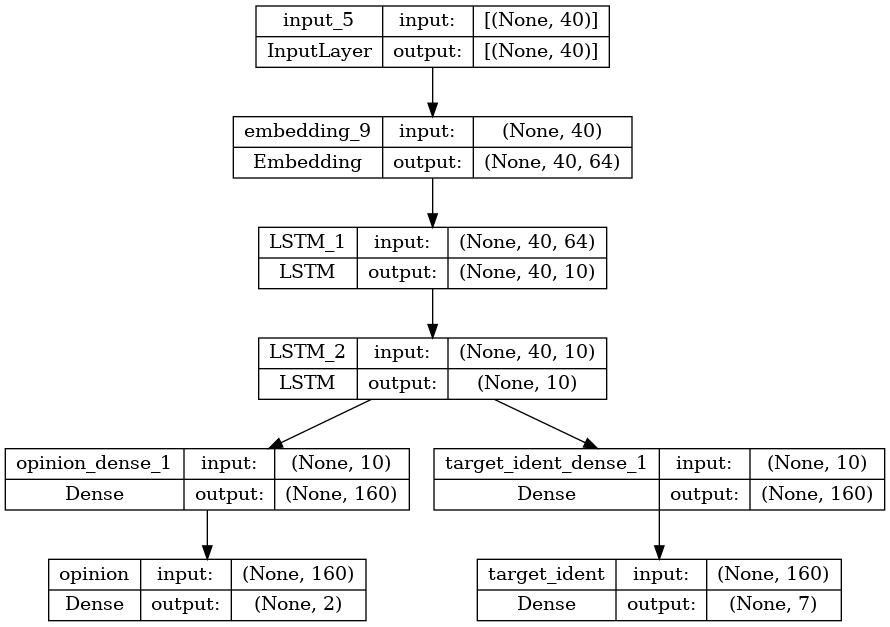

In [145]:
model = compile_model(model)

In [146]:
def train_model (model, epochs, X_train, X_val, y_train, y_val):

    history = model.fit(X_train, y_train, 
                validation_data=(X_val,y_val), 
                epochs=epochs, 
                callbacks=[callbacks()],
                verbose=0) 

    loss, opinion_loss, target_ident_loss, opinion_accuracy, target_ident_accuracy = model.evaluate(x=X_val, y=y_val)
    print(f'loss: {loss}')
    print(f'opinion_loss: {opinion_loss}')
    print(f'target_ident_loss: {target_ident_loss}')
    print(f'opinion_accuracy: {opinion_accuracy}')
    print(f'target_ident_accuracy: {target_ident_accuracy}')

    #visualizing training and validation results 
    plt.figure(figsize=(8, 10))

    plt.subplot(2, 2, 1)
    plt.title("Target Group Accuracy")
    plt.plot(history.history["target_ident_accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_target_ident_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title("Target Group Loss")
    plt.plot(history.history["target_ident_loss"], label="Training Loss")
    plt.plot(history.history["val_target_ident_loss"], label=" Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title("Hateful/Non-Hateful Accuracy")
    plt.plot(history.history["opinion_accuracy"], label=" Accuracy")
    plt.plot(history.history["val_opinion_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.title("Hateful/Non-Hateful Loss")
    plt.plot(history.history["opinion_loss"], label= "Training Loss")
    plt.plot(history.history["val_opinion_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    return model

Epoch 30: early stopping
28/28 [==============================] - 1s 18ms/step - loss: 2.1420 - opinion_loss: 0.1942 - target_ident_loss: 1.9478 - opinion_accuracy: 0.9353 - target_ident_accuracy: 0.1455
loss: 2.1419737339019775
opinion_loss: 0.1941782385110855
target_ident_loss: 1.9477956295013428
opinion_accuracy: 0.9353348612785339
target_ident_accuracy: 0.14549653232097626


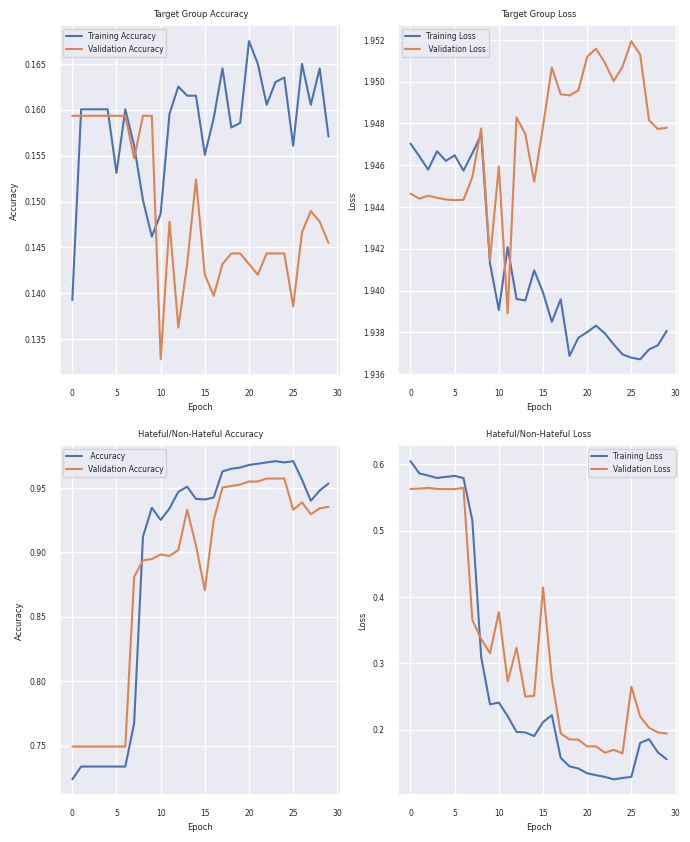

In [147]:
model = train_model (model, 50, X_train, X_val, y_train, y_val)

With this first simple model we can get an idea on how we can build upon it to improve. The challenge is to be able to produce good accuracy from both outputs.
From observing the accuracy and loss graphs above from each output we can see the following: 

- Hatful/Non-Hateful : Within this model output we can see that it starts to over fit around the number 6 epoch. To improve this I should add some regularization techniques and maybe add more layers to the model. I will add a dropout layer to the model after the LSTM unit. I will also add dropout to the LSTM units as well to see if this helps with accuracy of the model. However it does deem that it is predicting relatively well and may not need a huge amount of adjustment

- Target Group : This output is having more trouble predicting. The accuracy is around 0.2, which is not great. It appears again from the graph that it could be overfitting. I will do a similair process as the other output and add Dropout to help with overfitting.

In [174]:
def save_model(model, model_name):
    model.save(f"../project/save_models/{model_name}.keras")


In [175]:
save_model(model, "model_1")

In [190]:
def load_saved_model(model_name):
    saved_model = keras.models.load_model(f"../project/save_models/{model_name}.keras")

    return saved_model


In [191]:
model = load_saved_model("model_1")

In [192]:
def test_model(model, X_test, y_test):
    labels = {"0": "Hateful", "1" :"Non_Hateful"}
    
    y_pred_opinion = np.argmax(model.predict(X_test)[0], axis=1)
    y_test_opinion = y_test[0]

    y_pred_target = np.argmax(model.predict(X_test)[1], axis=1)
    y_test_target = y_test[1]

    conf_matrix_opinion = confusion_matrix(y_pred_opinion, y_test_opinion)
    conf_matrix_target = confusion_matrix(y_pred_target,y_test_target)

    plt.figure(figsize=(12, 8))
    sns.set(font_scale = 0.5)

    plt.subplot(1, 2, 1)
    plt.title("Hateful / Non Hateful")
    ax = sns.heatmap(conf_matrix_opinion, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 ,xticklabels=labels.values(), yticklabels=labels.values())
 
    ax.set_xlabel("Predicted", labelpad=20)
    ax.set_ylabel("Actual", labelpad=20)
    
    plt.subplot(1, 2, 2)
    plt.title("Target Group")
    ax = sns.heatmap(conf_matrix_target, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500,xticklabels=encoder_dict["target_ident"].keys(), yticklabels=encoder_dict["target_ident"].keys())
 
    ax.set_xlabel("Predicted", labelpad=20)
    ax.set_ylabel("Actual", labelpad=20)
    plt.show()

    precision_opinion = precision_score(y_test_opinion, y_pred_opinion, average="weighted")
    recall_opinion = recall_score(y_test_opinion, y_pred_opinion, average="weighted")
    f1score_opinion = f1_score(y_test_opinion, y_pred_opinion, average="weighted")
    accuracy_opinion = accuracy_score(y_test_opinion, y_pred_opinion)

    precision_target = precision_score(y_test_target, y_pred_target, average="weighted")
    recall_target = recall_score(y_test_target, y_pred_target, average="weighted")
    f1score_target = f1_score(y_test_target, y_pred_target, average="weighted")
    accuracy_target = accuracy_score(y_test_target, y_pred_target)

    print(f"Opinion Accuracy = {accuracy_opinion}") 
    print(f"Opinion Precision = {precision_opinion}")
    print(f"Opinion Recall = {recall_opinion}")
    print(f"Opinion F1 Score = {f1score_opinion}")
    print("\n")
    print(f"Target Accuracy = {accuracy_target}") 
    print(f"Target Precision = {precision_target}")
    print(f"Target Recall = {recall_target}")
    print(f"Target F1 Score = {f1score_target}")

23/23 [==============================] - 0s 15ms/step


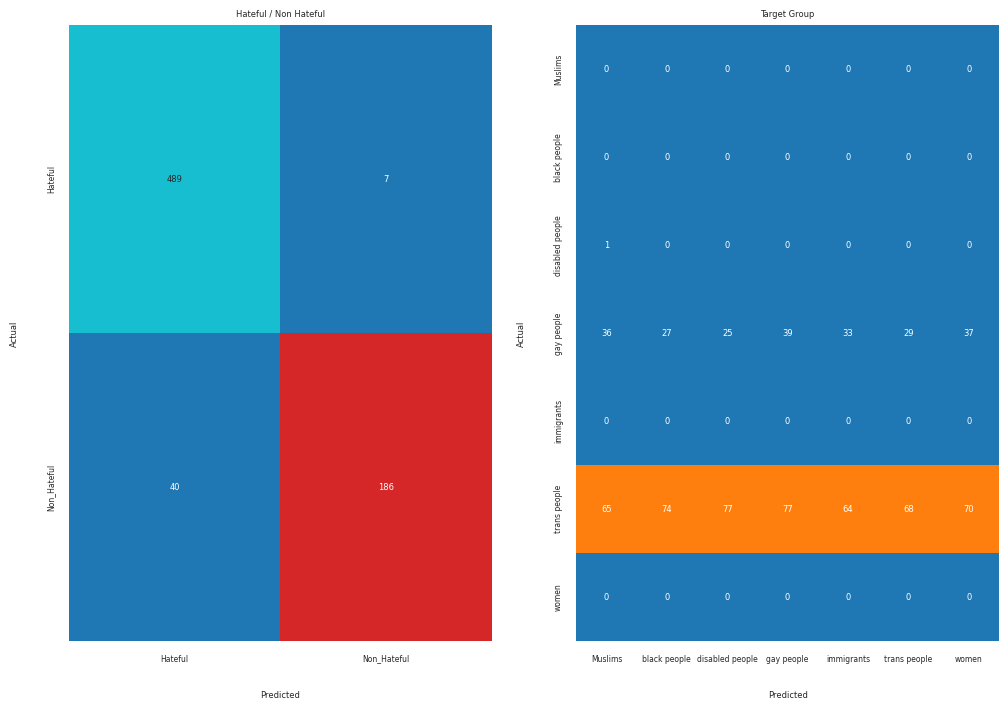

Opinion Accuracy = 0.9349030470914127
Opinion Precision = 0.9423476207176594
Opinion Recall = 0.9349030470914127
Opinion F1 Score = 0.9364186287483962


Target Accuracy = 0.1481994459833795
Target Precision = 0.04618137346301492
Target Recall = 0.1481994459833795
Target F1 Score = 0.0675068201311094


/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [193]:
test_model(model, X_test, y_test)

When running the test data, we can see that the categorization of the Hateful and Non Hateful text was pretty good. This does ensure that that output is working relatively fine. I will see if the dropout is needed or not!

However we can see that the other output is not very poorly. There is no consistency on the predictions at all.

### improving the base model

In [220]:
def base_model_2(inputs):
    embed = Embedding(804, 64, input_length=40)(inputs)
    LSTM_1 = LSTM(10,return_sequences=True,dropout=0.2, name ="LSTM_1") (embed)
    LSTM_2 = LSTM(10,return_sequences=True,dropout=0.2, name= "LSTM_2") (LSTM_1)
    LSTM_3 = LSTM(10,return_sequences=True,dropout=0.2, name ="LSTM_3") (LSTM_2)
    LSTM_4 = LSTM(10,return_sequences=False,dropout=0.2, name= "LSTM_4") (LSTM_3)
    Drop_o = Dropout(rate=0.5, name="Dropout_o") (LSTM_4)
    
    
    o_dense_1 = Dense(160, activation="relu", name="opinion_dense_1") (Drop_o)
    t_dense_1 = Dense(160, activation="relu", name="target_ident_dense_1") (LSTM_4)
    o_dense_2 = Dense(50, activation="relu", name="opinion_dense_2") (o_dense_1)
    t_dense_2 = Dense(50, activation="relu", name="target_ident_dense_2") (t_dense_1)

    return o_dense_2, t_dense_2

In [221]:
model_2 = final_model(inputs, base_model_2(inputs))

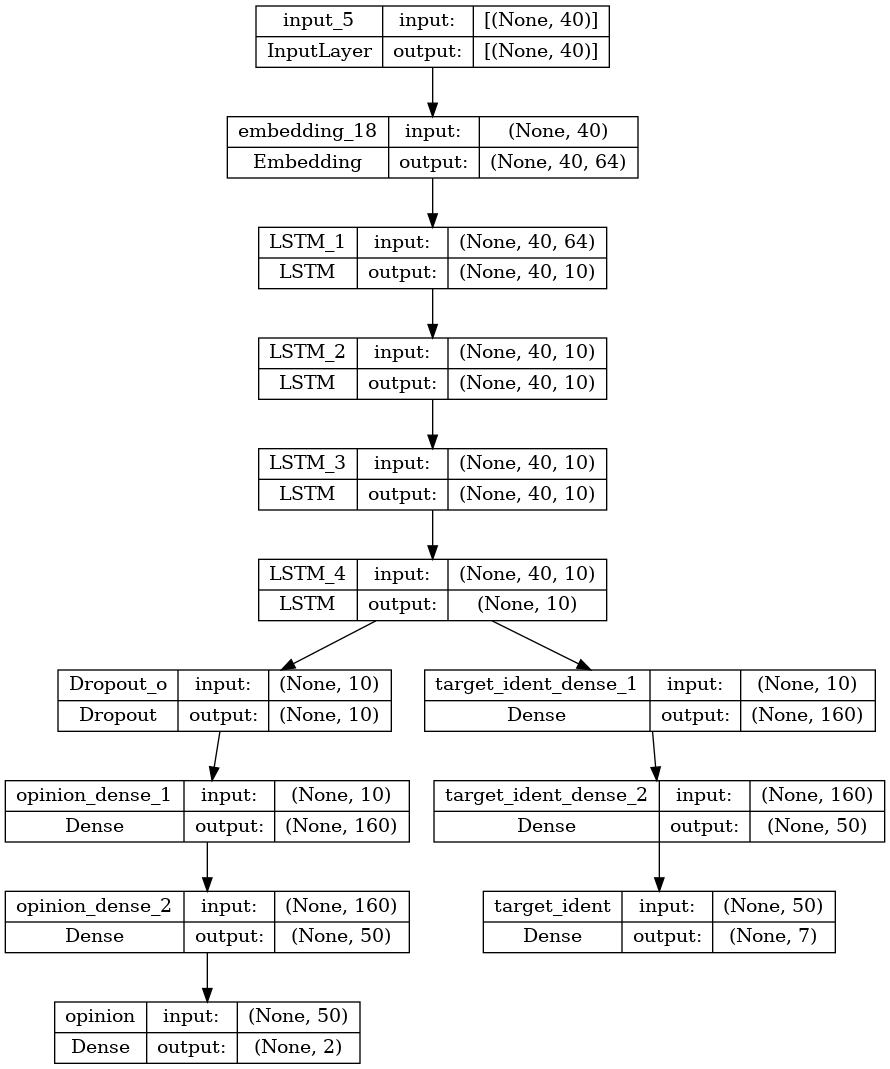

In [222]:
model_2 = compile_model(model_2)

Epoch 27: early stopping
28/28 [==============================] - 1s 36ms/step - loss: 1.4800 - opinion_loss: 0.1045 - target_ident_loss: 1.3755 - opinion_accuracy: 0.9734 - target_ident_accuracy: 0.3614
loss: 1.4800258874893188
opinion_loss: 0.10447888821363449
target_ident_loss: 1.3755470514297485
opinion_accuracy: 0.9734411239624023
target_ident_accuracy: 0.36143186688423157


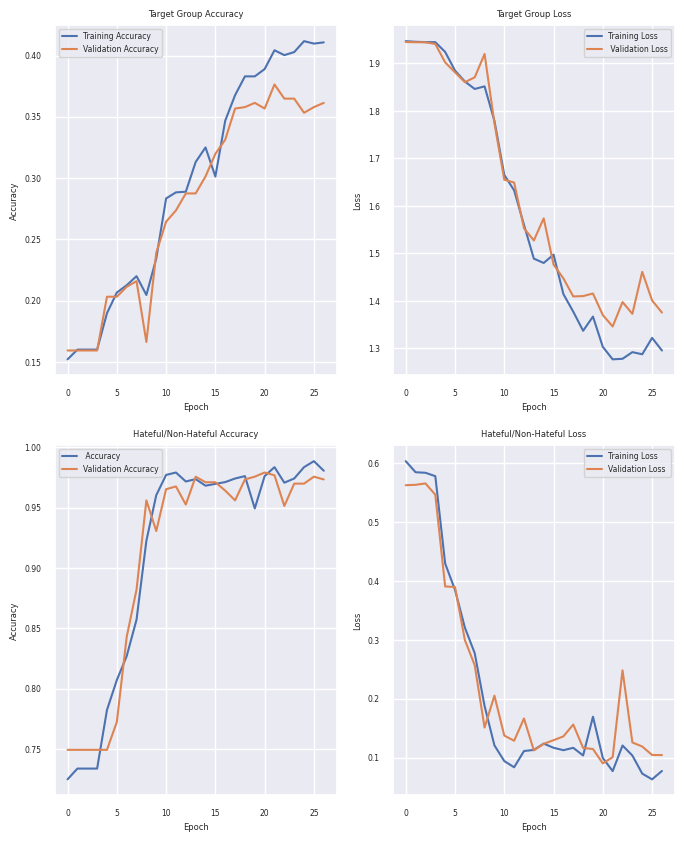

In [223]:
model_2 = train_model (model_2, 100, X_train, X_val, y_train, y_val)

In [224]:
save_model(model_2, "model_2")

In [225]:
model_2 = load_saved_model("model_2")

23/23 [==============================] - 1s 25ms/step


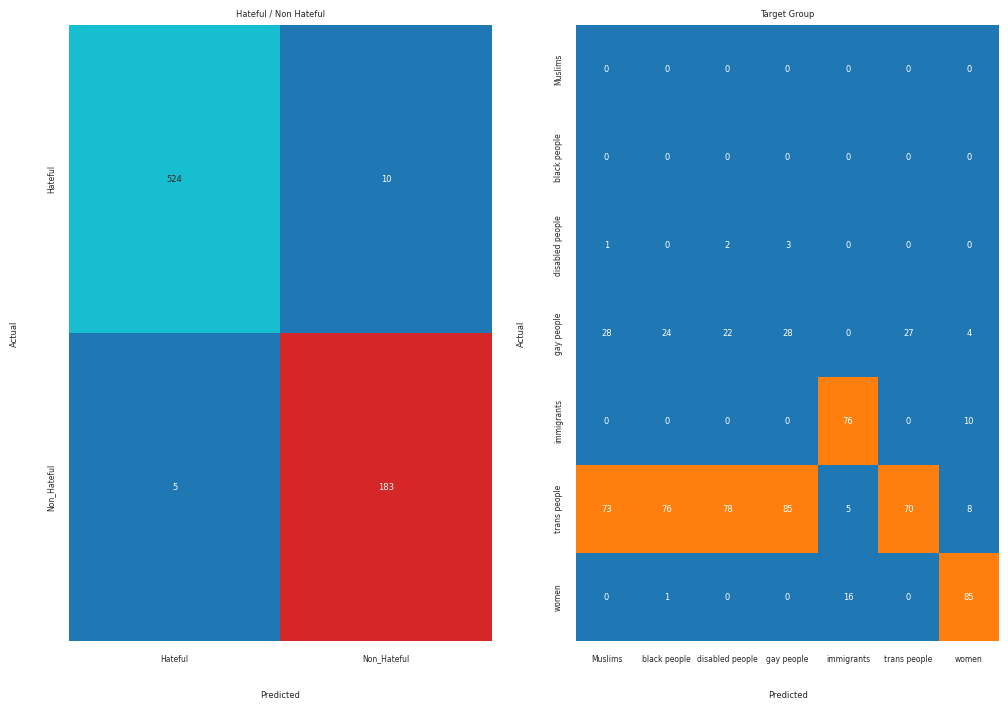

Opinion Accuracy = 0.9792243767313019
Opinion Precision = 0.9791698812124615
Opinion Recall = 0.9792243767313019
Opinion F1 Score = 0.9791369145701004


Target Accuracy = 0.36149584487534625
Target Precision = 0.3469508628095918
Target Recall = 0.36149584487534625
Target F1 Score = 0.31173068703821055


/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [226]:
test_model(model_2, X_test, y_test)

### Model 3

In [207]:
def base_model_3(inputs):
    embed = Embedding(804, 64, input_length=40)(inputs)
    LSTM_1 = LSTM(10,return_sequences=True,dropout=0.2, name ="LSTM_1") (embed)
    LSTM_2 = LSTM(10,return_sequences=True,dropout=0.2, name= "LSTM_2") (LSTM_1)
    LSTM_3 = LSTM(10,return_sequences=True,dropout=0.2, name ="LSTM_3") (LSTM_2)
    LSTM_4 = LSTM(10,return_sequences=False,dropout=0.2, name= "LSTM_4") (LSTM_3)
    
    Drop_o = Dropout(rate=0.5, name="Dropout_o") (LSTM_4)
    
   
    
    o_dense_1 = Dense(160, activation="relu", name="opinion_dense_1") (Drop_o)
    t_dense_1 = Dense(160, activation="relu", name="target_ident_dense_1") (LSTM_4)
    
    Drop_o_2 = Dropout(rate=0.2, name="Dropout_o_2") (o_dense_1)
    
   
    #Drop_t_3 = Dropout(rate=0.2, name="Dropout_t_2") (t_dense_1)

    o_dense_2 = Dense(50, activation="relu", name="opinion_dense_2") (Drop_o_2)
    t_dense_2 = Dense(50, activation="relu", name="target_ident_dense_2") (t_dense_1)
    
    
    



    return o_dense_2, t_dense_2

In [208]:
model_3 = final_model(inputs, base_model_3(inputs))

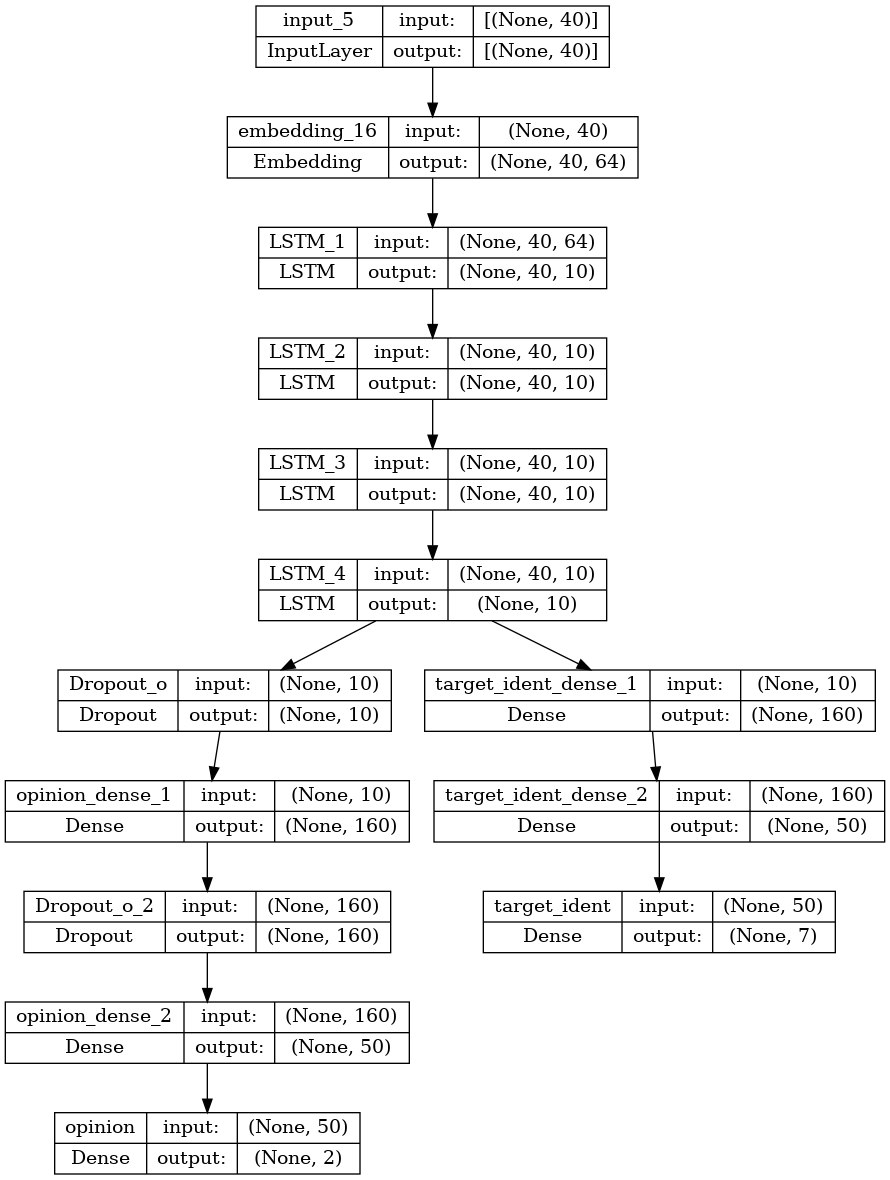

In [209]:
model_3 = compile_model(model_3)

Within this model I have decided to create a callbacks function. I have adjusted the build model function to accommodate this. I have now added in a learning rate callback.The callback is named ReduceLROnPlateau. During training it will monitor the validation loss and if it does not improve after a set amount of epochs 

In [215]:
def callbacks():
    # used in all the models
    early_stopping = EarlyStopping(monitor="val_loss", 
                                   mode="min", 
                                   verbose=1, 
                                   patience=5)
    #used within the third model
    lr_callback = ReduceLROnPlateau(monitor="val_loss",
                                    factor=0.1,
                                    patience =5,
                                    min_lr=0.0001)


    return early_stopping, lr_callback 

Epoch 43: early stopping
28/28 [==============================] - 1s 32ms/step - loss: 0.5523 - opinion_loss: 0.1691 - target_ident_loss: 0.3831 - opinion_accuracy: 0.9503 - target_ident_accuracy: 0.9446
loss: 0.5522978901863098
opinion_loss: 0.16914956271648407
target_ident_loss: 0.3831482231616974
opinion_accuracy: 0.9503464102745056
target_ident_accuracy: 0.9445727467536926


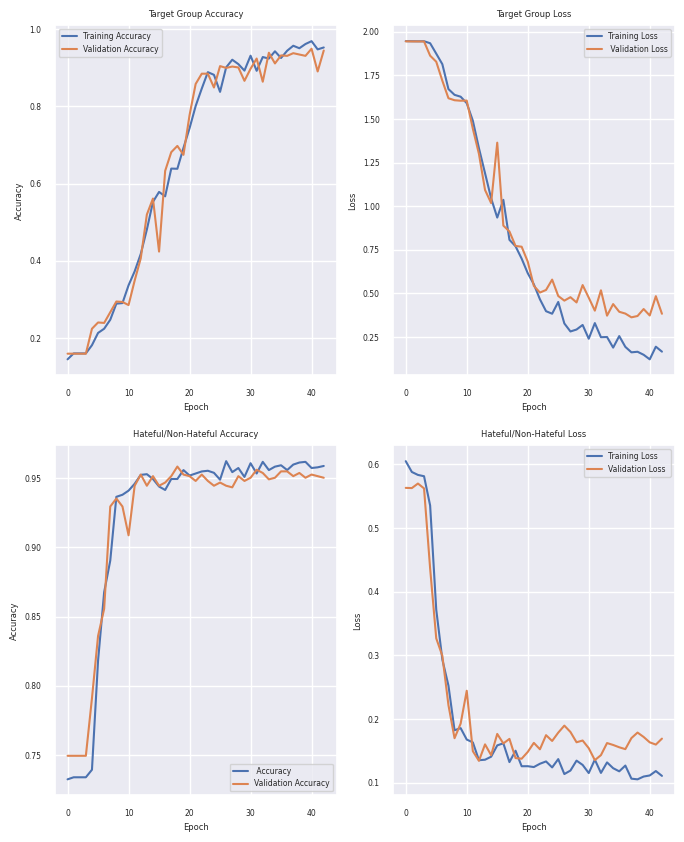

In [211]:
model_3 = train_model (model_3, 100, X_train, X_val, y_train, y_val)

In [212]:
save_model(model_3, "model_3")

In [213]:
model_3 = load_saved_model("model_3")

23/23 [==============================] - 1s 34ms/step


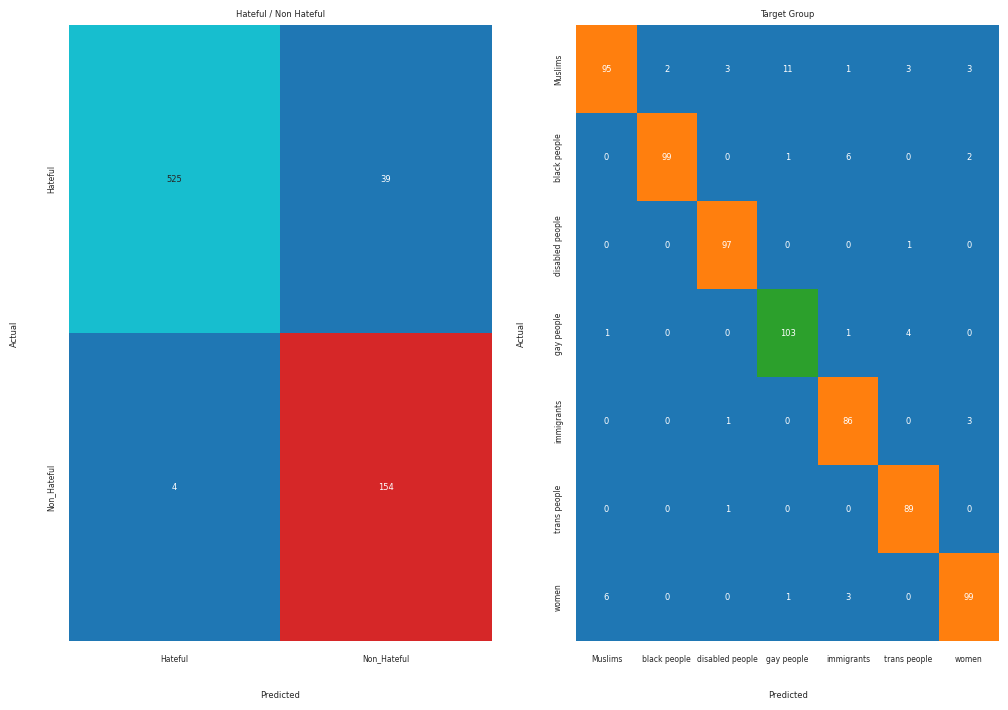

Opinion Accuracy = 0.9404432132963989
Opinion Precision = 0.9425680565326736
Opinion Recall = 0.9404432132963989
Opinion F1 Score = 0.9384274202926265


Target Accuracy = 0.925207756232687
Target Precision = 0.9294604395059903
Target Recall = 0.925207756232687
Target F1 Score = 0.9259746530942383


In [214]:
test_model(model_3, X_test, y_test)